<a href="https://colab.research.google.com/github/EVA4-RS-Group/Phase2/blob/master/S2_mobilenet_v2_custom_dataset/Training/EVA4_S2_mobilnet_v2_transfer_learning_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading Libraries

In [1]:
pip install torch-lr-finder

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!rm -rf final_images
!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/s2/final_images_ver2.zip
!unzip -q final_images_ver2.zip
!mv /content/final_images_ver2 /content/final_images
!rm -rf /content/__MACOSX
!find /content/final_images -name '.DS_Store' -type f -delete

In [4]:
# Load modules/models from EVA course
!rm -rf Modules
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv ./Phase2/Modules ./Modules
!rm -rf Phase2
#print("Loaded EVA4 Modules")
from Modules import *

  pip install torch-lr-finder -v --global-option="amp"


In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

# 2. Load Data & Set Data Loaders
We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [6]:
from Modules import *

In [8]:
find_mean_standard_deviation("/content/final_images/")

['Small QuadCopters', 'Winged Drones', 'Large QuadCopters', 'Flying Birds']
[0.53713346 0.58979464 0.62127595] [0.36370101 0.41305828 0.47454762] [0.27420551 0.25534403 0.29759673] 1898777428


In [9]:
split_test_train_data('/content/final_images', tstRatio = 0.3)

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones', 'testData.csv', 'trainData.csv']
6421
3309
3097
4609
0
0


In [10]:
batch_size = 192
# class_sample_count = [10, 1, 20, 3, 4] # dataset has 10 class-1 samples, 1 class-2 samples, etc.
# weights = 1 / torch.Tensor(class_sample_count)
# weights = weights.double()
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, batch_size)
# trainloader = torch.utils.data.DataLoader(trainDataset, batch_size = batch_size, sampler = sampler)

# target_list = torch.tensor(natural_img_dataset.targets)
# target_list = target_list[torch.randperm(len(target_list))]

# class_count = [i for i in get_class_distribution(natural_img_dataset).values()]
# class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
# class_weights

# class_weights_all = class_weights[target_list]
# class_weights_all

# weighted_sampler = WeightedRandomSampler(
#     weights=class_weights_all,
#     num_samples=len(class_weights_all),
#     replacement=True
# )

# train_loader = DataLoader(dataset=natural_img_dataset, shuffle=False, batch_size=8, sampler=weighted_sampler)

In [11]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5404, 0.5918, 0.6219],[0.2771, 0.2576, 0.2998])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5404, 0.5918, 0.6219],[0.2771, 0.2576, 0.2998])
    ]),
}

# data_dir = 'hymenoptera_data'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
#  = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

trnTransform = data_transforms['train'] 
trainSet = DroneDataset(train=True, transform = trnTransform)

tstTransform = data_transforms['val']
testSet = DroneDataset(train= False, transform = tstTransform)

dataloaders = {'train': torch.utils.data.DataLoader(trainSet, batch_size= batch_size, 
                                                    shuffle=True, num_workers=4),
               'val': torch.utils.data.DataLoader(testSet, batch_size= batch_size,
                                          shuffle=True, num_workers=4)}

dataset_sizes = {'train': len(trainSet),
                 'val':len(testSet)}

class_names = trainSet.classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']


# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

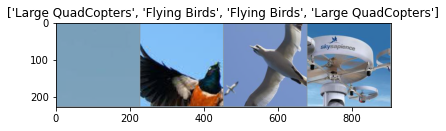

In [12]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:4,:,:,:])

imshow(out, title=[class_names[int(x)] for x in classes[0:4]])

#6. Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


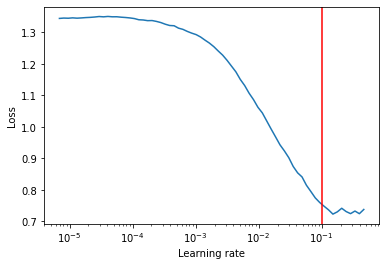

In [13]:
import torch.optim as optim
#from torch_lr_finder import LRFinder

model_ft = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_ft.classifier[1] = nn.Linear(1280, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_ft.classifier[1].parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.1) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [14]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.classifier[1].parameters(), lr=0.01, momentum=0.09)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.1, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs 
                                          epochs=25)

# 7. Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [15]:
model_res, plotData = train_model(model_ft, dataloaders, dataset_sizes, device, criterion, optimizer_ft, scheduler,
                       num_epochs=5)

Epoch 0/4
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.7998 Acc: 0.7252
val Loss: 0.4813 Acc: 0.8633

Epoch 1/4
----------
train Loss: 0.5385 Acc: 0.8250
val Loss: 0.3824 Acc: 0.8765

Epoch 2/4
----------
train Loss: 0.4686 Acc: 0.8435
val Loss: 0.3451 Acc: 0.8858

Epoch 3/4
----------
train Loss: 0.4443 Acc: 0.8462
val Loss: 0.3201 Acc: 0.8919

Epoch 4/4
----------
train Loss: 0.4237 Acc: 0.8476
val Loss: 0.3043 Acc: 0.8963

Training complete in 5m 10s
Best val Acc: 0.896347


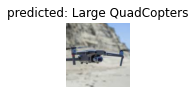

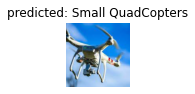

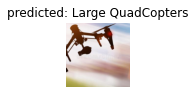

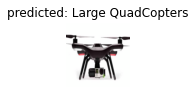

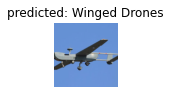

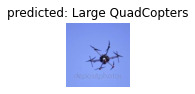

In [16]:
visualize_model(model_res, dataloaders, class_names, device,6,"visualize_1.jpg")

<Figure size 432x288 with 0 Axes>

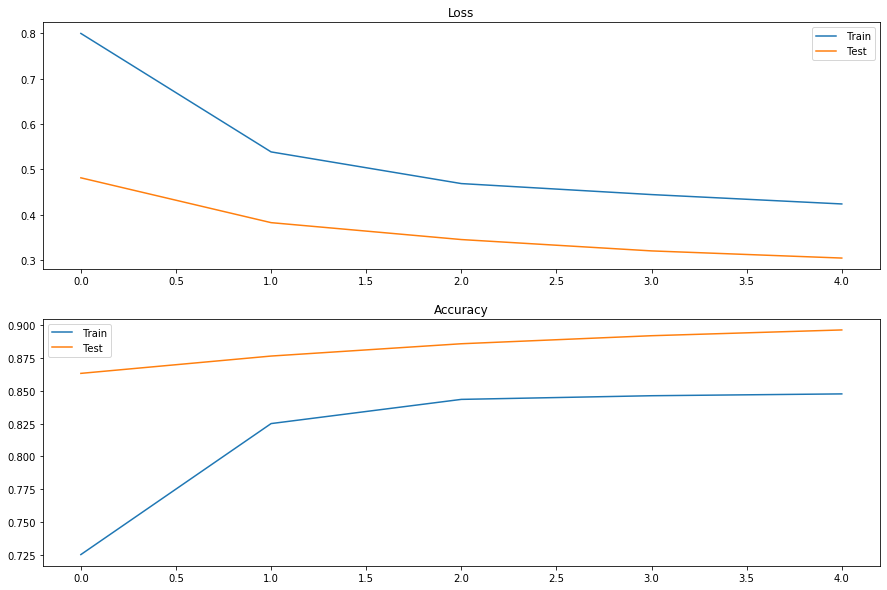

In [17]:
PlotGraph(plotData,"loss_accuracy_1.jpg")

# 8. ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


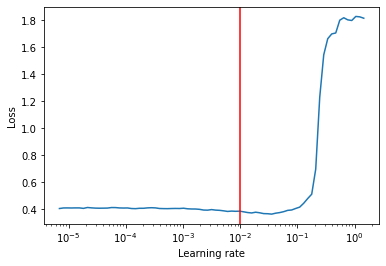

In [18]:
model_conv = model_res
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_conv = model_conv.to(device)

for param in model_conv.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_conv.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_conv, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.01) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [19]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = optim.lr_scheduler.OneCycleLR(optimizer_conv,
                                          max_lr=0.01, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs
                                          epochs=25,
                                          pct_start=0.2, div_factor=10, final_div_factor=100)


In [20]:
model_final, plotData = train_model(model_conv, dataloaders, dataset_sizes, device, criterion, optimizer_conv, scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.3477 Acc: 0.8728
val Loss: 0.2048 Acc: 0.9264

Epoch 1/4
----------
train Loss: 0.2820 Acc: 0.8944
val Loss: 0.2156 Acc: 0.9218

Epoch 2/4
----------
train Loss: 0.2506 Acc: 0.9039
val Loss: 0.1821 Acc: 0.9342

Epoch 3/4
----------
train Loss: 0.2349 Acc: 0.9113
val Loss: 0.1954 Acc: 0.9315

Epoch 4/4
----------
train Loss: 0.2114 Acc: 0.9198
val Loss: 0.1746 Acc: 0.9413

Training complete in 6m 13s
Best val Acc: 0.941289


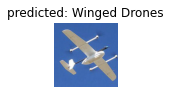

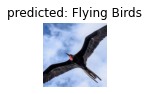

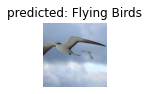

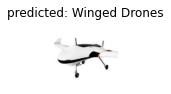

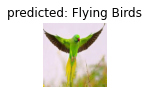

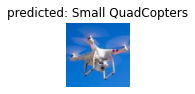

In [21]:
visualize_model(model_res, dataloaders, class_names, device,6,"visualize_2.jpg")
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

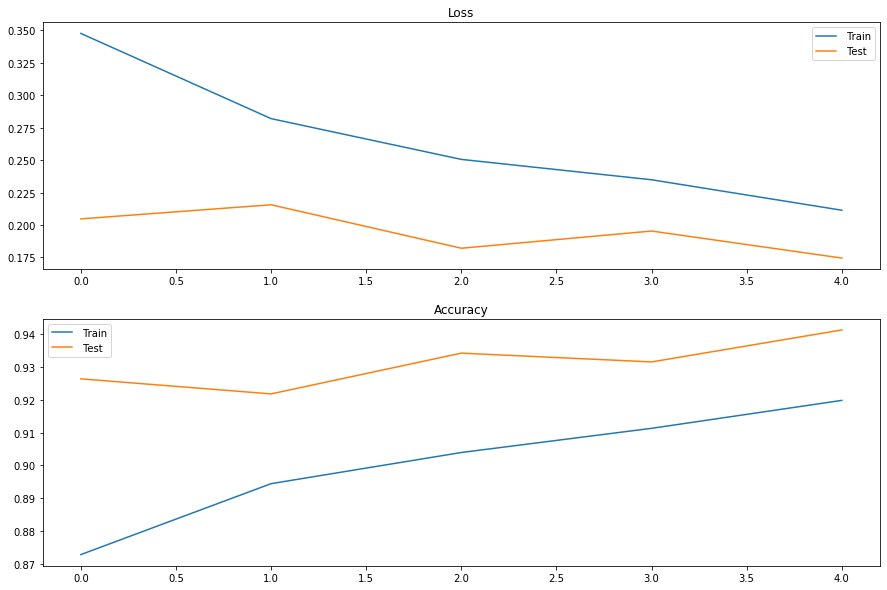

In [22]:
PlotGraph(plotData,"loss_accuracy_2.jpg")

<Figure size 432x288 with 0 Axes>

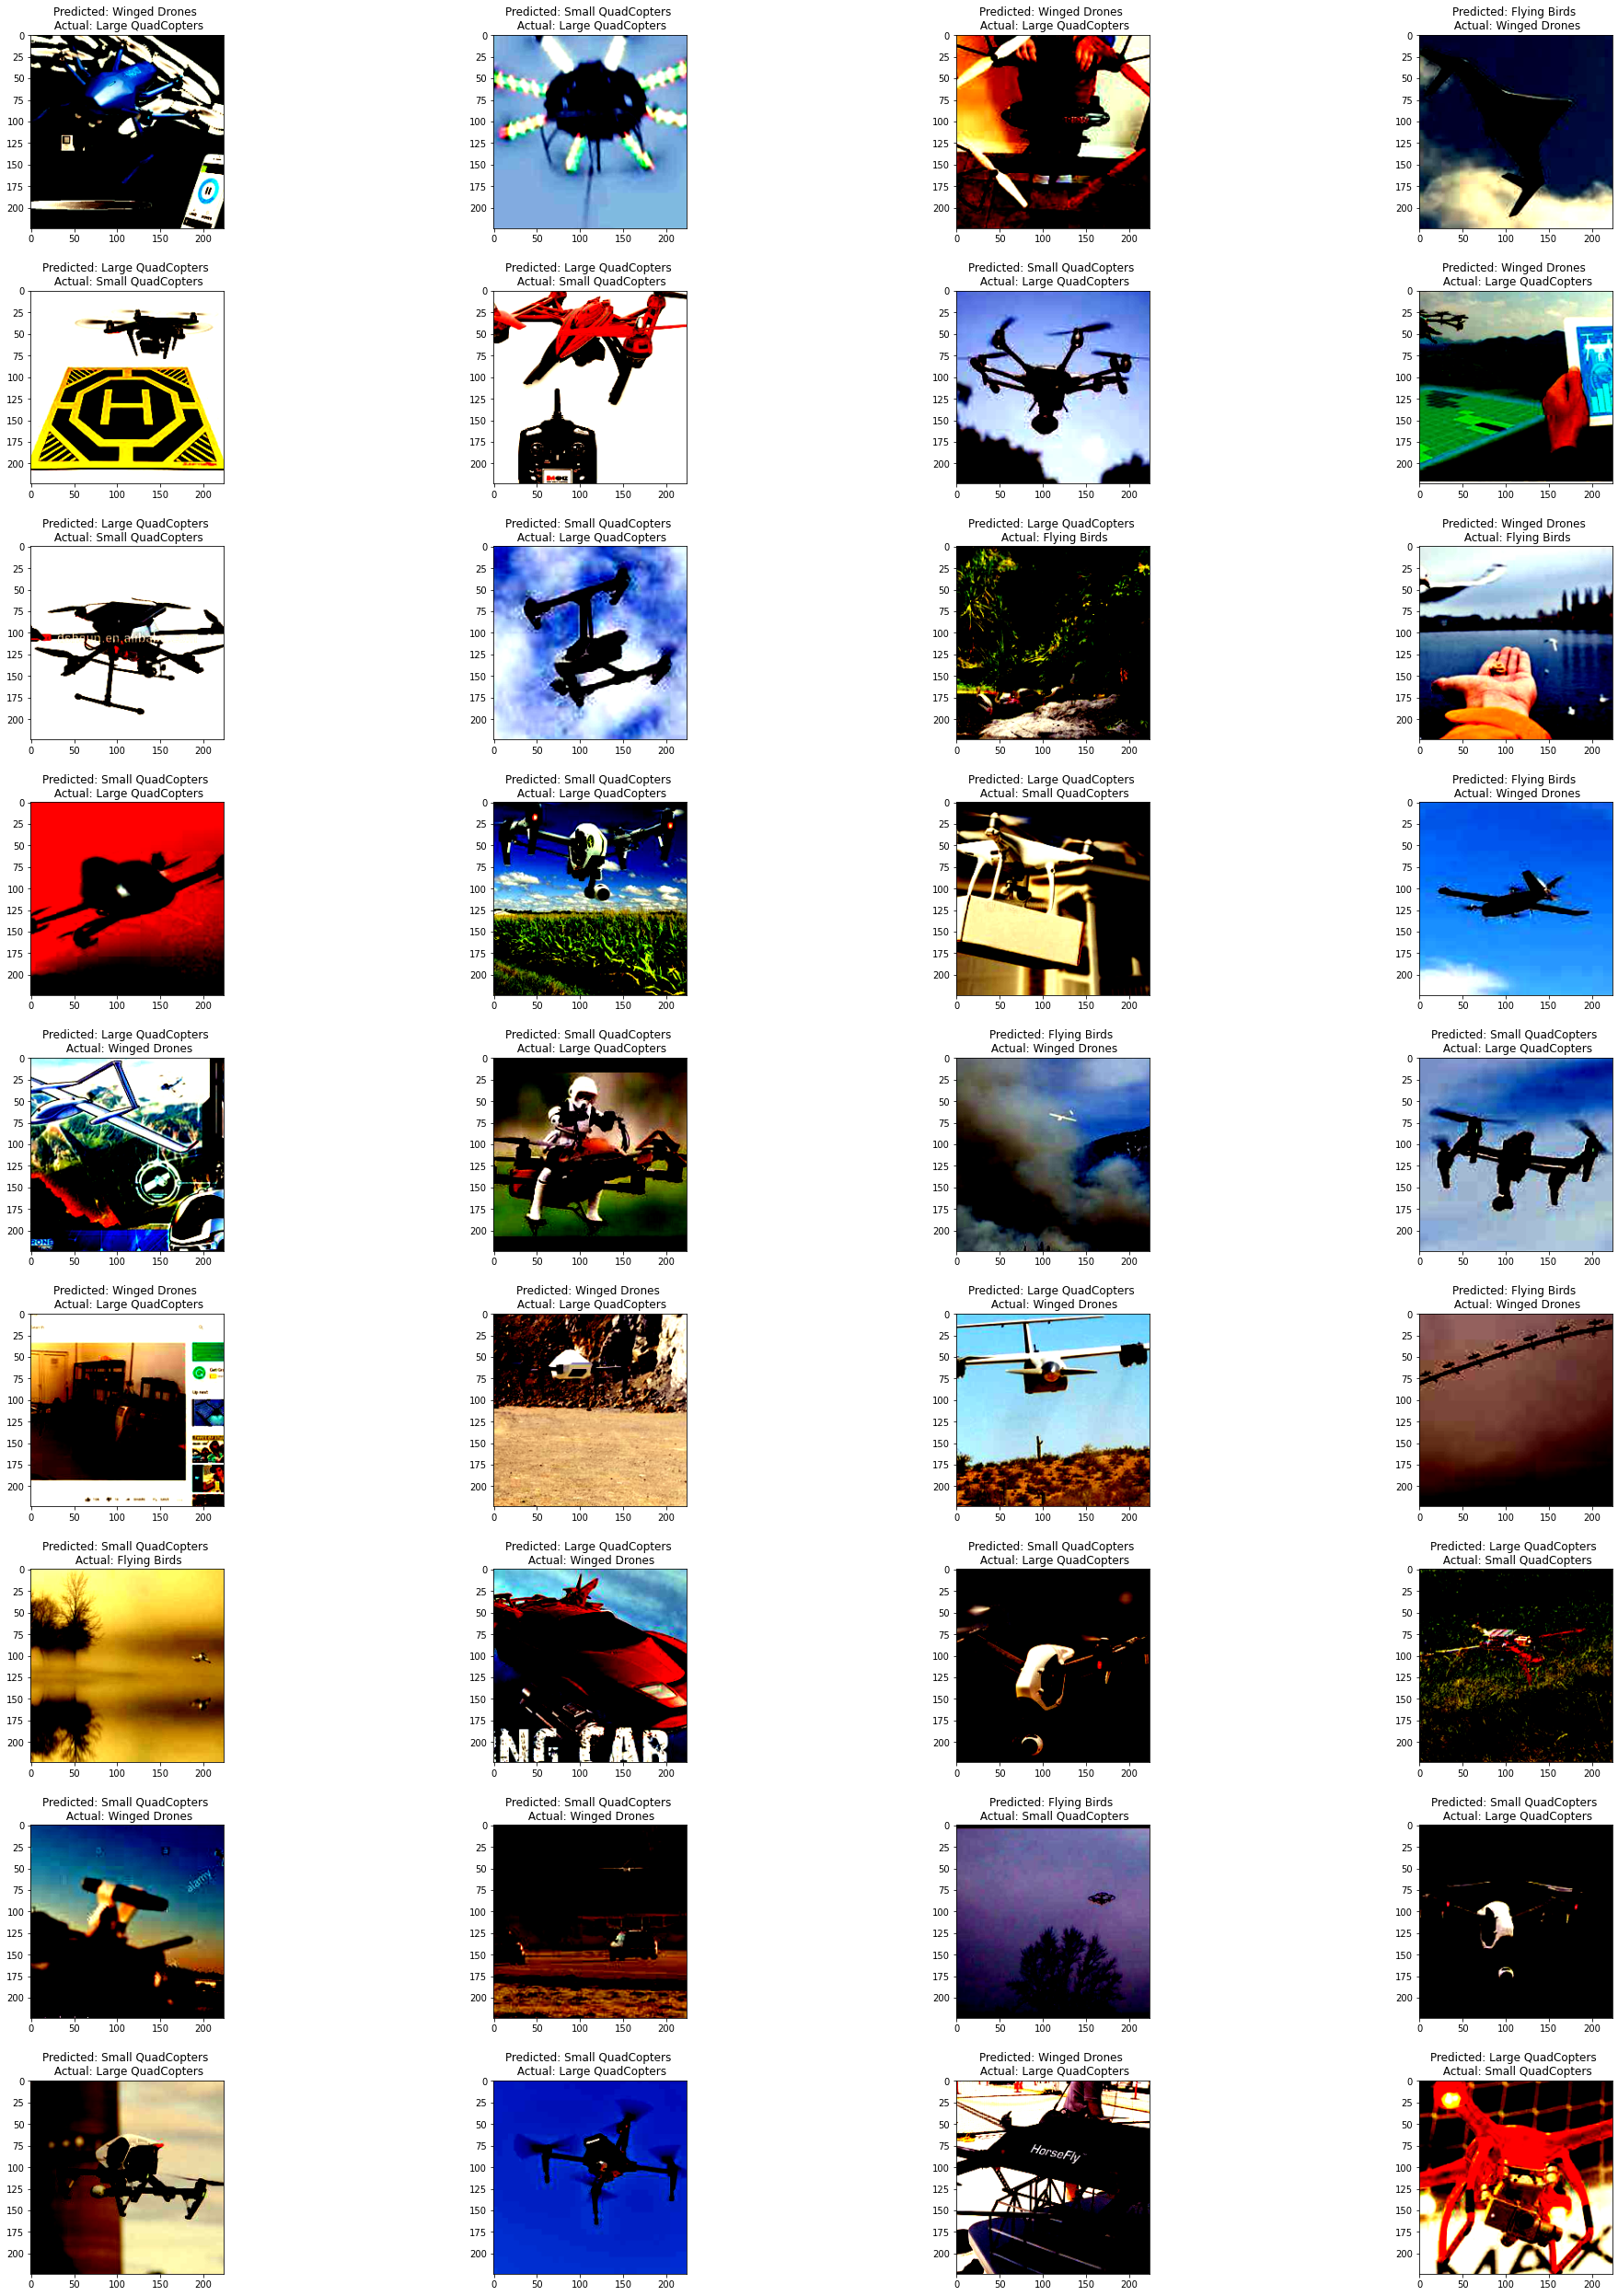

In [23]:
ShowMissclassifiedImages(model_final, dataloaders, class_names, device,save_as="misclassified.jpg")

# 9. Saving Model

In [ ]:
# Save GPU Model
torch.save(model_final.state_dict(), '/content/mobilenet_v2_custom_trained_gpu_v4b2.pt')

# Load CPU Model
device = torch.device('cpu')
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(1280, 4)
model.load_state_dict(torch.load('/content/mobilenet_v2_custom_trained_gpu_v4b2.pt',
                                 map_location=device))

# Saving Trace Model
model.eval()
# trace model with a dummy input
traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224))
traced_model.save('mobilenet_v2_custom_trained_v4b2.pt')